In [108]:
from control.matlab import *
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np

In [109]:
X_TORSO = 0.12
g = 9.807
SAMPLE_TIME = 0.005
Z_ROBOT = 0.78
Z_MODEL = 0.68
SWING_HEIGHT = 0.1
STEP_LENGTH = 0.2

In [110]:
def find_initial_conditions(step_length, dy_mid, x0, z_model, g, sample_time):
    """Find initial condition and single support duration for a symmetric piece of trajectory"""
    time_cons = np.sqrt(z_model / g)
    y_mid = 0
    orbital_energy = -g/(2 * z_model) * y_mid ** 2 + 0.5 * dy_mid **2
    y0 = -step_length / 2
    dy0 = np.sqrt(2 * (orbital_energy + g / (2 * z_model) * y0 ** 2))
    t_single_support = 2 * np.arcsinh(step_length/2/(time_cons *dy_mid)) * time_cons
    t_single_support = np.floor(t_single_support / sample_time) * sample_time
    tf = t_single_support / 2
    dx0 = -x0 / time_cons * np.sinh(tf / time_cons) / np.cosh(tf / time_cons)
    
    return [dx0, y0, dy0, t_single_support]
    

In [111]:
dy_mid = 0.06
x0 = 0.12
[dx0, y0, dy0, t_single_support] = find_initial_conditions(STEP_LENGTH, dy_mid, x0, Z_MODEL, g, SAMPLE_TIME)

In [112]:
A = [[0, 1, 0, 0], [g / Z_MODEL, 0, 0, 0], [0, 1, 0, 0], [0, 0, g / Z_MODEL, 0]]
B = [[0, 0], [1, 0], [0, 0], [0, 1]]
C = [[1, 0, 0, 0], [0, 0, 1, 0]]
D = [[0, 0], [0, 0]]

lipm = ss(A, B, C, D)
lipm_d = c2d(lipm , SAMPLE_TIME)

Ad = lipm_d.A
Bd = lipm_d.B
Cd = lipm_d.C
Dd = lipm_d.D

state0 = np.array([[x0], [dx0], [y0], [dy0]])
u0 = np.array([[0], [0]])


In [113]:
class ModelVars():
    
    def __init__(self, g, sample_time, z_model, t_single_support, Ad, Bd, Cd, Dd):
        
        self.g = g
        self.sample_time = sample_time
        self.z_model = z_model
        self.t_single_support = t_single_support
        self.Ad = Ad
        self.Bd = Bd
        self.Cd = Cd
        self.Dd = Dd
model_vars = ModelVars(g, SAMPLE_TIME, Z_MODEL, t_single_support, Ad, Bd, Cd, Dd)

In [115]:
init_robot_pos = [0, 0, Z_ROBOT]
foot_pos = []
foot_pos.append([-X_TORSO, 0, 0])
foot_pos.append([X_TORSO, 0, 0])
num_steps = 6

In [116]:
class SimStates():
    
    def __init__(self, body_pos, foot_pos, time_vec):
    
        self.body_pos = body_pos
        self.foot_pos = foot_pos
        self.time_vec = time_vec
    

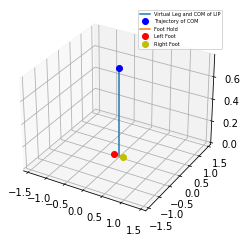

In [117]:
h_fig = plt.figure()
ax = h_fig.add_subplot(111, projection='3d')
h_leg = ax.plot3D(np.array([0, 0]), np.array([0, 0]), np.array([0, Z_ROBOT]), '-', label='Virtual Leg and COM of LIP')
h_com = ax.plot3D(init_robot_pos[0], init_robot_pos[1], init_robot_pos[2], 'bo', label='Trajectory of COM')
h_line_foot_hold = ax.plot3D(np.array(foot_pos)[:, 0], np.array(foot_pos)[:, 1], np.array(foot_pos)[:, 2],
                            label='Foot Hold')
h_line_left_foot = ax.plot3D(np.array(foot_pos)[0, 0], np.array(foot_pos)[0, 1], np.array(foot_pos)[0, 2], 'ro',
                            label='Left Foot')
h_line_right_foot = ax.plot3D(np.array(foot_pos)[1, 0], np.array(foot_pos)[1, 1], np.array(foot_pos)[1, 2], 'yo',
                            label='Right Foot')
ax.set_xlim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.set_ylim(-2*Z_ROBOT, 2*Z_ROBOT)
ax.legend(fontsize=5)

In [118]:
def cubic_poly_traj (way_points, time_points, t, vel_points=None):
    
    way_points = np.asarray(way_points)
    time_points = np.asarray(time_points)
    t = np.asarray(t).reshape(-1)
    
    if len(way_points.shape) == 1:
        n = 1
        p = way_points.shape[0]
    else:
        n = way_points.shape[0]
        p = way_points.shape[1]
        
    sample_time = t[1] - t[0]
    
    if vel_points is None:
        if n == 1:
            vel_points = np.zeros(p)
        else:
            vel_points = np.zeros((n, p))
    else:
        vel_points = np.asarray(vel_points)
    
    q = np.zeros((n, t.shape[0]))
    qd = np.zeros((n, t.shape[0]))
    qdd = np.zeros((n, t.shape[0]))
    
    coef_dim = 4
    coef_mat = np.zeros(((p - 1) * n, coef_dim))
    
    for i in range(p-1):
        
        final_time = time_points[i+1] - time_points[i]
        
        for j in range(n):
            
            ridx = i * n + j
            if n == 1:
                coef_mat[ridx, :] = gen_cubic_coeffs(way_points[i:i+2], vel_points[i:i+2], final_time)
            else:
                coef_mat[ridx, :] = gen_cubic_coeffs(way_points[j, i:i+2], vel_points[j, i:i+2], final_time)
            
    for i in range(t.shape[0]):
        
        for j in range(p-1):
            
            if (t[i] < time_points[j + 1] and t[i] >= time_points[j]) or (t[i] == time_points[-1]):
                
                q[:, i] = coef_mat[j * n:(j+1) * n, :].dot(np.array([1, t[i]-time_points[j], (t[i]-time_points[j])**2, (t[i]-time_points[j])**3]))
                qd[:, i] = coef_mat[j * n:(j+1) * n, 1:4].dot(np.array([1, 2*(t[i]-time_points[j]), 3*(t[i]-time_points[j])**2]))
                qdd[:, i] = coef_mat[j * n:(j+1) * n, 2:4].dot(np.array([2, 6*(t[i]-time_points[j])]))
            else:
                
                pass
    return [q, qd, qdd]
    
def gen_cubic_coeffs(pos_pts, vel_pts, final_time):
    
    x0 = pos_pts[0]
    dx0 = vel_pts[0]
    xf = pos_pts[1]
    dxf = vel_pts[1]
    
    coeff_vec = np.array([x0, dx0, 0, 0])
    t_mat0 = np.array([[1, final_time], [0, 1]])
    B = np.array([xf, dxf]) - t_mat0.dot(coeff_vec[0:2])
    inv_t_matf = np.array([[3 / final_time**2, -1 / final_time], [-2 / final_time**3, 1 / final_time**2]])
    coeff_vec[2:4] = inv_t_matf.dot(B)
    
    return coeff_vec

In [119]:
def get_swing_foot_traj(foot_pos0, foot_pos1, swing_height, time_stp0, time_stpf, sample_time):
    
    way_pts_xy = np.append(foot_pos0[0:2].reshape(2,1), foot_pos1[0:2].reshape(2,1), 1)
    time_pts_xy = np.array([time_stp0, time_stpf])
    time_vec_xy = np.arange(time_stp0, time_stpf, sample_time)
    [xy, xyd, xydd] = cubic_poly_traj(way_pts_xy, time_pts_xy, time_vec_xy)
    
    way_pts_z = [foot_pos0[2], foot_pos0[2]+swing_height, foot_pos1[2]]
    time_stp_mid = (time_stp0 + time_stpf) / 2
    time_pts_z = np.array([time_stp0, time_stp_mid, time_stpf])
    time_vec_z = np.arange(time_stp0, time_stpf, sample_time)
    [z, zd, zdd] = cubic_poly_traj(way_pts_z, time_pts_z, time_vec_z)
    
    q = np.append(xy, z).reshape(3, -1)
    qd = np.append(xyd, zd).reshape(3, -1)
    qdd = np.append(xydd, zdd).reshape(3, -1)
    
    return [q, qd, qdd]

In [120]:
walk_ready_points = np.array([[0, 0.67*x0], [0, 0], [Z_ROBOT, Z_MODEL]])
time_points = np.array([0, 1])
time_vec = np.arange(time_points[0], time_points[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(walk_ready_points, time_points, time_vec)
sim_state = SimStates(np.array([]), np.empty((3,1)), np.array([]))

sim_state.time_vec = np.append(sim_state.time_vec,time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q).reshape(3, -1)
sim_state.foot_pos[:] =  np.array([[-X_TORSO], [0], [0]])
sim_state.foot_pos = np.append(sim_state.foot_pos, [[X_TORSO], [0], [0]], 1)

walk_ready_points = np.append(walk_ready_points, np.array([[0], [0.1], [Z_MODEL]]), 1)
yoff = walk_ready_points[1, 2]
fhold_x = -x0
fhold_y = -y0 + yoff
sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x], [fhold_y], [0]], 1)
way_pts = walk_ready_points[:, 1:3]
vel_pts = np.array([[0, dx0], [0, dy0], [0, 0]])
time_pts = [1, 1.5]
time_vec = np.arange(time_pts[0], time_pts[1], SAMPLE_TIME)
[q, qd, qdd] = cubic_poly_traj(way_pts, time_pts, time_vec, vel_pts)
sim_state.time_vec = np.append(sim_state.time_vec,time_vec)
sim_state.body_pos = np.append(sim_state.body_pos, q, 1)

swing_foot_pos0 = sim_state.foot_pos[:, 0]
swing_foot_pos1 = sim_state.foot_pos[:, 2]

[q_swing, qd_swing, qdd_swing] = get_swing_foot_traj(swing_foot_pos0, swing_foot_pos1,
                                                     SWING_HEIGHT, time_pts[0], time_pts[1], SAMPLE_TIME)

In [128]:
def stance_sim(fhold_x, fhold_y, state0, u0, model_vars, sim_states):
    
    ts = model_vars.sample_time
    Ad = model_vars.Ad
    Bd = model_vars.Bd
    
    init_t = sim_states.time_vec[-1] + ts
    final_t = init_t + model_vars.t_single_support
    time_vec = np.arange(init_t, final_t, ts)
    
    n_steps = np.size(time_vec)
    states = np.zeros((state0.shape[0], n_steps))
    states[:, 0] = state0.reshape(-1)
    
    for idx in range(n_steps - 1):
        states[:, idx + 1] = np.matmul(Ad, states[:, idx]) + np.matmul(Bd, u0).reshape(-1)
    
    sim_states.time_vec = np.append(sim_states.time_vec, time_vec[:-1])
    new_states = np.array([[states[0, 1:]+fhold_x], [states[2, 1:]+fhold_y], model_vars.z_model * np.ones((1, n_steps - 1))])
    new_states = new_states.reshape(3, -1)
    sim_states.body_pos = np.append(sim_states.body_pos, new_states, 1)
    
    return [states, time_vec, sim_states]

def change_leg(state1, sim_states):
    
    xf  = state1[0]
    dxf = state1[1]
    yf  = state1[2]
    dyf = state1[3]
    
    x0 = -xf
    y0 = -yf 
    dx0 = dxf 
    dy0 = dyf
    state0 = np.array([[x0], [dx0], [y0], [dy0]])
    
    fhold_x = sim_states.body_pos[0, -1] - x0
    fhold_y = sim_states.body_pos[1, -1] - y0
    print(fhold_y)
    
    return [state0, fhold_x, fhold_y]
    

In [129]:
fhold_x1 = fhold_x
fhold_y1 = fhold_y
for stp in range(num_steps):
    
    fhold_x0 = fhold_x1
    fhold_y0 = fhold_y1
    
    [states, time_vec, sim_state] = stance_sim(fhold_x0, fhold_y0, state0, u0, model_vars, sim_state)
    
    [state0, fhold_x1, fhold_y1] = change_leg(states[:, -1], sim_state)
    sim_state.foot_pos = np.append(sim_state.foot_pos, [[fhold_x1], [fhold_y1], [0]], 1)
    
    [q, qd, qdd] = get_swing_foot_traj(sim_state.foot_pos[:, -3], sim_state.foot_pos[:, -1], SWING_HEIGHT,
                                      time_vec[0], time_vec[-1], SAMPLE_TIME)
    

4.618527782440651e-14
0.2044583220059309
0.004458322005991722
0.20891664401186588
0.008916644011927155
0.2133749660177996


In [125]:
sim_state.foot_pos

array([[-0.12      ,  0.12      , -0.12      ,  0.11554168, -0.12445832,
         0.11108336, -0.12891664,  0.10662503, -0.13337497],
       [ 0.        ,  0.        ,  0.2       , -0.00445832,  0.19554168,
        -0.00891664,  0.19108336, -0.01337497,  0.18662503],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]])

In [107]:
a = np.array([2, 3, 4,5,6])
np.ones((1,2))

sim_state.time_vec.shape

(2970,)